In [4]:
from google.colab import auth
auth.authenticate_user()

In [5]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=8O8Z5GAb-uyt9zEGGGA9saqxeV_e77rbiLwEs-EaRrw&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g50sqSVCrib0gTlmdc6NlQUC2s4egMOgHn_iG7qiqUEGGYXBi0I4dg

Successfully saved authorization token.


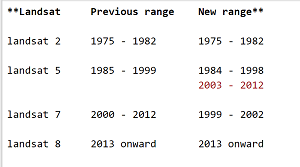

In [7]:
import time
ts = time.time()
timestamp = int(ts)

cloud = 30
spatialResolution = 30
fullPoints = ee.FeatureCollection('users/heromiya/gt-pt-10000')
GoogleDriveFolderLC = "LandCoverMapGen-LC-"+ str(timestamp)
GoogleDriveFolderAA = 'LandCoverMapGen-AA'
nSample = 10000
numberOfTrees = 100

filterDist = 370000

ROI = [
    {'cityName': 'PHL-Laguna', 'LatMax': 14.6, 'LatMin': 14.1, 'LonMax': 121.6, 'LonMin': 120.9, 'yearBegin':2004, 'yearEnd':2005, 'doyFilter':ee.Filter.And(ee.Filter.greaterThanOrEquals('doy',  1), ee.Filter.lessThanOrEquals('doy',  366)), 'doyFilterLandsat': ee.Filter.dayOfYear(1,366)},
    {'cityName': 'PHL-Laguna-Wet', 'LatMax': 14.6, 'LatMin': 14.1, 'LonMax': 121.6, 'LonMin': 120.9, 'yearBegin':2015, 'yearEnd':2016, 'doyFilter':ee.Filter.And(ee.Filter.greaterThanOrEquals('doy',  153), ee.Filter.lessThanOrEquals('doy',  305)), 'doyFilterLandsat': ee.Filter.dayOfYear(153, 305)},
    {'cityName': 'PHL-Laguna-Dry', 'LatMax': 14.6, 'LatMin': 14.1, 'LonMax': 121.6, 'LonMin': 120.9, 'yearBegin':2015, 'yearEnd':2016, 'doyFilter':ee.Filter.Or(ee.Filter.greaterThanOrEquals('doy',  306), ee.Filter.lessThanOrEquals('doy',  152)), 'doyFilterLandsat': ee.Filter.Or(ee.Filter.dayOfYear(1, 152),ee.Filter.dayOfYear(306, 366))}
]

AA = []
year= ''
roi= ''
kernel = ee.Kernel.gaussian(1)
outExt = ''

def cloudMask(img):
  return img.updateMask(img.select('BQA').lt(64))

def addDist(feature):
  return feature.set({'d': feature.distance(outExt)})

# print(ROI)
for roi in range(0, len(ROI), 1):
  cityName = ROI[roi]['cityName']
  yearBegin = ROI[roi]['yearBegin']
  yearEnd = ROI[roi]['yearEnd']
  for year in range(yearBegin, yearEnd, 1):
    nSampleClass = []
    outExt = ee.Geometry.Rectangle([ ROI[roi]['LonMin'], ROI[roi]['LatMin'], ROI[roi]['LonMax'], ROI[roi]['LatMax']])
    gtBounds = fullPoints.geometry().bounds().getInfo()["coordinates"]
    gtLonMin = gtBounds[0][0][0]
    gtLatMin = gtBounds[0][0][1]
    gtLonMax = gtBounds[0][2][0]
    gtLatMax = gtBounds[0][2][1]

    gtExt = ee.Geometry.Rectangle([gtLonMin, gtLatMin, gtLonMax, gtLatMax])

    if (yearBegin >= 2013):
        bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']
        FCCbands = ['B5', 'B4', 'B3']
        TextureBand = ['B5']
        bandsClassify = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B5_1']
        bandsGLCM = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B5_asm',    'B5_contrast',"B5_corr",  "B5_var",     "B5_idm",   "B5_savg", "B5_svar",   "B5_sent",    "B5_ent",   "B5_dvar",    "B5_dent",  "B5_imcorr1", "B5_imcorr2","B5_maxcorr", "B5_diss",  "B5_inertia", "B5_shade", "B5_prom"]
        Landsat = 'LANDSAT/LC08/C01/T1'

    elif (yearBegin >= 1999 and yearBegin <= 2002):
        bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']
        bandsClassify = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7','B4_1']
        bandsGLCM = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B4_asm', 'B4_contrast',"B4_corr", "B4_var","B4_idm","B4_savg", "B4_svar","B4_sent","B4_ent","B4_dvar","B4_dent","B4_imcorr1", "B4_imcorr2","B4_maxcorr","B4_diss","B4_inertia","B4_shade","B4_prom"]
        FCCbands = ['B4', 'B3', 'B2']
        TextureBand = ['B4']
        Landsat = 'LANDSAT/LE07/C01/T1'

    elif (yearBegin >= 1984 and yearBegin <= 1998 or yearBegin >=2003 and yearBegin <=2012):
        bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']
        bandsClassify = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7','B4_1']
        bandsGLCM = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B4_asm', 'B4_contrast',"B4_corr", "B4_var","B4_idm","B4_savg", "B4_svar","B4_sent","B4_ent","B4_dvar","B4_dent","B4_imcorr1", "B4_imcorr2","B4_maxcorr","B4_diss","B4_inertia","B4_shade","B4_prom"]
        FCCbands = ['B4', 'B3', 'B2']
        TextureBand = ['B4']
        Landsat = 'LANDSAT/LT05/C01/T1'

    elif (yearBegin >= 1975 and yearBegin <= 1982):
        bands = ['B4_median', 'B5_median', 'B6_median','B7_median','B6_median_1']
        bandsClassify = ['B4_median', 'B5_median', 'B6_median', 'B7_median']
        FCCbands = ['B6_median', 'B5_median', 'B4_median']
        TextureBand = ['B6_median']
        Landsat = 'LANDSAT/LM02/C01/T2'
    else:

      print("Year out of range !!!")
      break

    gtYearBegin = yearBegin
    gtYearEnd = yearEnd

    yearSubset = fullPoints.filter(ee.Filter.And(ee.Filter.greaterThanOrEquals('year', gtYearBegin), ee.Filter.lessThanOrEquals('year', gtYearEnd), ROI[roi]['doyFilter']))

    dist = yearSubset.map(addDist)
    distFilter = ee.Filter.lt('d', filterDist)
    points = dist.filter(ee.Filter.eq('class', 1)).filter(distFilter).limit(nSample,"d")
    nSampleClass.insert(0,points.size()) 

    for i in range(2, 5, 1):
      randomSampleClass = dist.filter(ee.Filter.eq('class', i)).filter(distFilter).limit(nSample,"d")
      nSampleClass.insert(i-1, randomSampleClass.size())
      points = points.merge(randomSampleClass)

    nRandomSample = points.size().getInfo()
    if(nRandomSample > 300):
        print(cityName + "," + str(yearBegin)+","+str(nRandomSample))

    if (Landsat == 'LANDSAT/LM02/C01/T2'):
        landsatImg = ee.ImageCollection(Landsat) \
                        .filterDate(str(gtYearBegin) + '-01-01',str(gtYearEnd) + '-12-31') \
                        .filter(ROI[roi]['doyFilterLandsat']) \
                        .filterMetadata('CLOUD_COVER_LAND', 'less_than', 50) \
                        .map(cloudMask).reduce(ee.Reducer.median())
        landsatImgInt = landsatImg.toByte()

    else:

        landsatCol = ee.ImageCollection(Landsat) \
                          .filterDate(str(gtYearBegin) + '-01-01',str(gtYearEnd) + '-12-31') \
                          .filter(ROI[roi]['doyFilterLandsat'])

        landsatImg    = ee.Algorithms.Landsat.simpleComposite(landsatCol,50,cloud,40,True)
        landsatImgInt = ee.Algorithms.Landsat.simpleComposite(landsatCol,50,cloud,40,False)

    gtImage = landsatImg.clip(gtExt)
    gtImageInt = landsatImgInt.clip(gtExt)
    gtImageTexture = gtImage.addBands(gtImageInt.select(TextureBand).entropy(kernel))

    outImage = landsatImg.clip(outExt)
    outImageInt = landsatImgInt.clip(outExt)
    outImageTexture = outImage.addBands(outImageInt.select(TextureBand).entropy(kernel))

    alg = ee.Classifier.smileRandomForest(numberOfTrees)
    trainInput = gtImageTexture.sampleRegions(points,['class'],1)
    classifier = alg.train(trainInput, 'class', bandsClassify)

    classified = outImageTexture.select(bandsClassify).classify(classifier).focal_mode()
    compositeImage = outImage.select(FCCbands)

    trainAccuracy = classifier.confusionMatrix()
    AA.append(ee.Feature(outExt,
                        {
                          'cityName': cityName,
                          'year': str(yearBegin) + '-' + str(yearEnd),
                          'ts': str(timestamp),
                          'OA': trainAccuracy.accuracy(),
                          'KA': trainAccuracy.kappa(),
                          'CA': trainAccuracy.consumersAccuracy(),
                          'PA': trainAccuracy.producersAccuracy(),
                          'nSample': nSampleClass
                        }))
    
    lcTask = ee.batch.Export.image.toDrive(**{
      'image': classified,
      'description': 'LC-' + cityName + '_' + str(yearBegin) + '-' + str(yearEnd) + '_' + str(timestamp),
      'folder': GoogleDriveFolderLC,
      'fileNamePrefix': 'LC-' + cityName + '_' + str(yearBegin) + '-' + str(yearEnd) + '_' + str(timestamp),
      'scale': spatialResolution,
      'region': outExt
    })

    lcTask.start()

    fccTask = ee.batch.Export.image.toDrive(**{
      'image': compositeImage,
      'description':    'FCC-' + cityName + '-' + str(yearBegin) + '-' + str(yearEnd) + '-' + str(timestamp),
      'folder': GoogleDriveFolderLC,
      'fileNamePrefix': 'FCC-' + cityName + '-' + str(yearBegin) + '-' + str(yearEnd) + '-' + str(timestamp),
      'scale': spatialResolution,
      'region': outExt
    })

    fccTask.start()

aaTask = ee.batch.Export.table.toDrive(**{
  'collection': ee.FeatureCollection(AA),
  'description': 'AA-'+ str(timestamp),
  'folder': GoogleDriveFolderAA,
  'fileNamePrefix': 'AA-'+ str(timestamp),
  })

aaTask.start()

PHL-Laguna,2004,40000
